# Notebook Generating Two Input/Output for HH 

In [1]:
from brian2 import *
from brian2tools import *


prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA

In [22]:
np.shape(input_current)

(1497,)

In [4]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [5]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [31]:
I = TimedArray(input_current, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))


inp_trace = np.array([input_current])
n0, n1 = inp_trace.shape

out_trace = np.array([voltage[:n1]])

WARNING    "n" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [35]:
mon.v/mV

array([[-65.        , -65.        , -65.        , ..., -74.45678717,
        -74.45205975, -74.44733469]])

In [24]:
np.shape(out_trace[0])

(1497,)

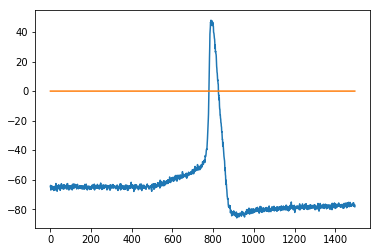

In [7]:
plot(out_trace[0]);
plot(inp_trace[0]);

In [8]:
out_trace

array([[-64.79072805, -63.86959387, -67.04494851, ..., -78.15798366,
        -76.94720516, -78.28342677]])

In [9]:
inp_trace

array([[0., 0., 0., ..., 0., 0., 0.]])

In [10]:
# Model for modelfitting
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
Cm=1*ufarad*cm**-2 * area, El=-65*mV, EK=-90*mV, ENa=50*mV, VT=-63*mV)

In [11]:
n_opt = NevergradOptimizer()

In [27]:
# pass parameters to the NeuronGroup
res, error, output_traces = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * nA, output=out_trace*mV, dt=dt,
                                   gl=[1e-8*siemens*cm**-2 * area, 1e-4*siemens*cm**-2 * area],
                                   g_na=[1*msiemens*cm**-2 * area, 200*msiemens*cm**-2 * area],
                                   g_kd=[1*msiemens*cm**-2 * area, 100*msiemens*cm**-2 * area],
                                   n_rounds=5, n_samples=30, optimizer=n_opt,)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exponential_euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]


Runtime
parameters [[8.72865401e-09 3.27048787e-05 6.03124224e-06]
 [6.41266057e-09 3.09149209e-05 1.00335947e-05]
 [3.34879141e-09 2.92919225e-05 2.87390748e-06]
 [1.11630123e-08 3.09474815e-05 9.11879806e-06]
 [1.10514825e-08 2.00276623e-05 4.86700913e-06]
 [1.61504845e-08 1.94866422e-05 1.21733572e-05]
 [7.06539480e-09 1.10767913e-05 1.20596429e-05]
 [1.45214002e-08 2.77143753e-05 1.18862309e-05]
 [1.36593270e-08 2.87977390e-05 7.63907613e-06]
 [1.61653200e-08 2.99366386e-05 1.51056743e-05]
 [5.66517901e-09 3.16105072e-05 1.21482421e-05]
 [1.63970139e-08 2.18214996e-05 1.32689888e-05]
 [1.38058458e-08 1.16763738e-05 1.78017818e-05]
 [1.36344420e-08 8.83670982e-06 1.55482496e-05]
 [1.51147904e-08 3.23480578e-05 1.15423738e-05]
 [8.77564271e-09 9.33536440e-06 7.14100869e-06]
 [1.40095418e-08 2.33188021e-05 1.46967718e-05]
 [5.15692813e-09 2.67367004e-05 9.65056748e-06]
 [6.54863380e-09 1.48505535e-05 3.79300712e-06]
 [8.05814909e-09 1.17672829e-05 9.36474818e-06]
 [9.26702652e-09 1.23

In [13]:
output_traces.transpose()[1]

### Vizualize Output Traces

In [14]:
np.shape(output_traces[0])

(1497, 30)

In [15]:
np.array(output_traces[0]).transpose()[0]

array([ 0.00000000e+00, -2.19711831e-05, -4.39285428e-05, ...,
       -7.11713717e-02, -7.11692846e-02, -7.11671983e-02])

In [16]:
np.array(output_traces[0]).transpose()[1]

array([ 0.00000000e+00, -2.17334694e-05, -4.34462916e-05, ...,
       -7.28306141e-02, -7.28279952e-02, -7.28253771e-02])

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

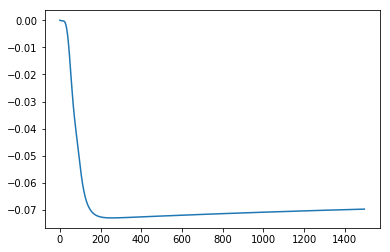

In [37]:
for n in range(5):
    plt.figure()
    for ii in range(30):
        plot(np.array(output_traces[n]).transpose()[ii])
        savefig('a.jpg')

## Calculate RMS

In [28]:
from sklearn.metrics import mean_squared_error

y = out_trace[0]

rms_list = []
for row in output_traces[0].transpose():
    print(np.array(row))
    rms = np.sqrt(mean_squared_error(y, row))
    rms_list.append(rms)
    print(rms)

[ 0.00000000e+00 -2.83619361e-05 -5.66872125e-05 ... -6.96629762e-02
 -6.96609331e-02 -6.96588908e-02]
68.85069799245115
[ 0.00000000e+00 -2.08378060e-05 -4.16470304e-05 ... -7.19765088e-02
 -7.19742705e-02 -7.19720329e-02]
68.8480102607155
[ 0.00000000e+00 -1.08826610e-05 -2.17411470e-05 ... -6.80122096e-02
 -6.80116828e-02 -6.80111561e-02]
68.85430980776788
[ 0.00000000e+00 -3.62696671e-05 -7.24969382e-05 ... -6.98057404e-02
 -6.98030515e-02 -6.98003642e-02]
68.8494971131566
[ 0.00000000e+00 -3.59073963e-05 -7.17803669e-05 ... -6.81824706e-02
 -6.81806990e-02 -6.81789284e-02]
68.85217825191076
[ 0.00000000e+00 -5.24678872e-05 -1.04881021e-04 ... -6.86347906e-02
 -6.86318470e-02 -6.86289058e-02]
68.84964392199502
[ 0.00000000e+00 -2.29584776e-05 -4.59030485e-05 ... -7.17186611e-02
 -7.17162873e-02 -7.17139144e-02]
68.8477898701977
[ 0.00000000e+00 -4.71774215e-05 -9.43016530e-05 ... -6.91604835e-02
 -6.91574540e-02 -6.91544267e-02]
68.84930550522103
[ 0.00000000e+00 -4.43776567e-05 -8

In [19]:
# give information to the optimizer
print('correct:', params_correct, '\n output:', res)
print('error', error)

correct: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06} 
 output: {'gl': 1.7177908517725702e-08, 'g_na': 4.686271108243526e-06, 'g_kd': 1.6111300235897804e-05}
error [0.00014079 0.00014079 0.00014079]


In [20]:
# visualization of the results
start_scope()
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(res, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage1 = mon.v[0]/mV

WARNING    "n" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


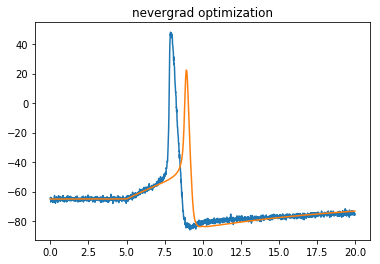

In [21]:
plt.figure()
plot(np.arange(len(voltage))*dt/ms, voltage);
plot(np.arange(len(voltage1))*dt/ms, voltage1);
plt.title('nevergrad optimization')
plt.show()